In [1]:
import requests
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In order to work with queries returning over 1000 results, I utilized the Elasticsearch aggregations supported by the API.

In [3]:
# Desired search term. Add double quotes within single quotes for exact match, i.e.: query = '"cats"'# Desired search term. Add double quotes within single quotes for exact match, i.e.: query = '"cats"'# Desired search term. Add double quotes within single quotes for exact match, i.e.: query = '"cats"'



query = 'cats'

# Elasticsearch query structure.

dic = {
  "q": f"{query}",
  "limit": 100,
  "aggs": {
    "years": {
      "terms": {
        "size": 1000,
        "field": "date_start",
        "missing": "9999" #(if query returns any null values)
      }
    }
  }
}

# Aggregate results
institute_response = requests.post("https://api.artic.edu/api/v1/artworks/search", json=dic)
response_json = institute_response.json()["aggregations"]["years"]["buckets"]
df_elastic = pd.DataFrame(response_json)


In [4]:
df_elastic

,key,doc_count
0,1600,181
1,1601,126
2,1700,125
3,1845,116
4,-100,106
...,...,...
600,1773,1
601,1784,1
602,1793,1
603,1836,1


In [3]:
# Sort by year
df_elastic.columns = ['year', 'count']
df_elastic.sort_values(by=['year'])

,year,count
315,-3000,5
519,-1870,1
455,-1550,2
520,-1390,1
521,-1295,1
...,...,...
454,2017,3
314,2018,6
86,2019,23
518,2020,2


In [4]:
# Verify Elasticsearch query by making sure it returns the same total number of results as original json query.
df_elastic['count'].sum()

7269

In [5]:
# Drop null values to allow accurate year-based statistical analysis.
df_elastic = df_elastic[df_elastic.year != 9999]

In [6]:
# Calculate mean and median entries per year.
mean_acq = df_elastic['count'].mean().round(0)
print(f"The average year with 1 or more artworks in the collection has {mean_acq} artworks featuring cats.")
median_acq = df_elastic['count'].median().round(0)
print(f"The median year has {median_acq} such works.")

The average year with 1 or more artworks in the collection has 12.0 artworks featuring cats.
The median year has 6.0 such works.


In [7]:
# Find years where the greatest number of query-related artworks were created in terms of percentage.
df_elastic_pct = df_elastic.assign(proportion = df_elastic['count'].div(df_elastic['count'].sum()).map('{:.2%}'.format))
df_elastic_pct.iloc[:15]

,year,count,proportion
0,1600,181,2.50%
1,1601,126,1.74%
2,1700,125,1.73%
3,1845,116,1.60%
4,-100,106,1.46%
5,1850,100,1.38%
6,1801,87,1.20%
7,1875,78,1.08%
8,1800,75,1.04%
9,1970,73,1.01%


In [8]:
# Select and print second and third column to meet assignment requirements
df_elastic_pct.iloc[:, 1:3]

,count,proportion
0,181,2.50%
1,126,1.74%
2,125,1.73%
3,116,1.60%
4,106,1.46%
...,...,...
600,1,0.01%
601,1,0.01%
602,1,0.01%
603,1,0.01%


In [9]:
# Select and print first four rows
df_elastic_pct.iloc[:4, :]

,year,count,proportion
0,1600,181,2.50%
1,1601,126,1.74%
2,1700,125,1.73%
3,1845,116,1.60%


In [10]:
# Query the DataFrame to determine how many years had an above-average amount of cat-related artworks.
len(df_elastic.query('count > @mean_acq'))

173

605 entries will be far too many for a legible bar graph. Therefore, we will group by decade. Unfortunately, Pandas is unable to parse dates before the year 1600, and Datetime is unable to work with negative years, i.e. "Before Common Era" years. The following cells constitute a workaround for these limitations.

In [11]:
# Create new column indicating if an integer is positive or negative, allowing for the elimination of "negative" years from the DataFrame for processing, without losing information.
df_neg_test = df_elastic.copy()
df_neg_test['+/-'] = (df_neg_test['year'] < 0).astype(int)
df_neg_test['+/-'] = df_neg_test['+/-'].replace([0, 1], ['+', '-'])
df_neg_test['year'] = df_neg_test['year'].abs()
df_neg_test.head()

,year,count,+/-
0,1600,181,+
1,1601,126,+
2,1700,125,+
3,1845,116,+
4,100,106,-


In [12]:
# Ensure previous operation didn't alter the count values of dataframe; returns True if values were altered. May return "True" after the first run of the notebook due to memory-related bugs with Jupyter.
df_alteration_test = df_elastic
(False in (df_neg_test.iloc[:, 0:2].values == df_alteration_test.copy().iloc[:, 0:2].abs().values))

False

In [13]:
# Convert year column from integer to datetime -> Period -> PeriodIndex
df_dt_test = df_neg_test.copy()
df_dt_test['year'] = df_dt_test['year'].apply(lambda x: dt.date(year=x, month=2, day=2))
df_dt_test.iloc[:]
df_period_test = df_dt_test
df_period_test['year'] = df_period_test['year'].apply(lambda x: pd.Period(x, freq='M'))
df_index_test = df_period_test
df_index_test['Period_Index'] = pd.PeriodIndex(df_dt_test['year'], freq='M')
df_periodindex = df_index_test.drop(['year'], axis=1)
df_periodindex = df_periodindex.set_index('Period_Index')
df_periodindex.sort_values('Period_Index')


,count,+/-
Period_Index,,
1-02,5,+
50-02,1,+
50-02,4,-
100-02,106,-
100-02,2,+
...,...,...
2017-02,3,+
2018-02,6,+
2019-02,23,+


In [14]:
# Resample by decade, preserving distinction between positive and negative years.
df_resample_test=df_periodindex.groupby('+/-').resample('10A').sum()
df_resample_test

/tmp/ipykernel_25223/2262668284.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_resample_test=df_periodindex.groupby('+/-').resample('10A').sum()


count
+/- Period_Index       
+   1                 5
    11                0
    21                0
    31                0
    41                1
...                 ...
-   2960              0
    2970              0
    2980              0
    2990              0
    3000              5

[498 rows x 1 columns]

In [15]:
# Drop empty decades.
df_final = df_resample_test.loc[~(df_resample_test==0).all(axis=1)] # To sort, append .sort_values('count', ascending=False)
df_final.sort_values('Period_Index')

count
+/- Period_Index       
+   1                 5
    41                1
-   50                4
+   91                2
-   100             106
...                 ...
+   1981            129
    1991            147
    2001             89
    2011             74
-   3000              5

[128 rows x 1 columns]

In [16]:
# Reset index to allow for conversion from PeriodIndex to integer. 
df_finalfinal = df_final.reset_index()
df_finalfinal.columns = ['BCE', 'Period', 'Total']
df_finalfinal

,BCE,Period,Total
0,+,1,5
1,+,41,1
2,+,91,2
3,+,101,1
4,+,171,1
...,...,...,...
123,-,1290,1
124,-,1390,1
125,-,1550,2
126,-,1870,1


In [17]:
# Return negative values to DF, as we no longer need vectorized methods requiring PeriodIndex dtype.
df_finalfinal['Period'] = df_finalfinal['Period'].apply(lambda x: x.year)
df_finalfinal['Year'] = (df_finalfinal['BCE'].astype(str) + df_finalfinal['Period'].astype(str)).astype(int)

In [18]:
# Resort and reset index to present years in proper chronoligcal order for the bar graph.
df_seaborn = df_finalfinal.sort_values('Year').reset_index(drop=True)

<AxesSubplot:xlabel='Year', ylabel='Total'>

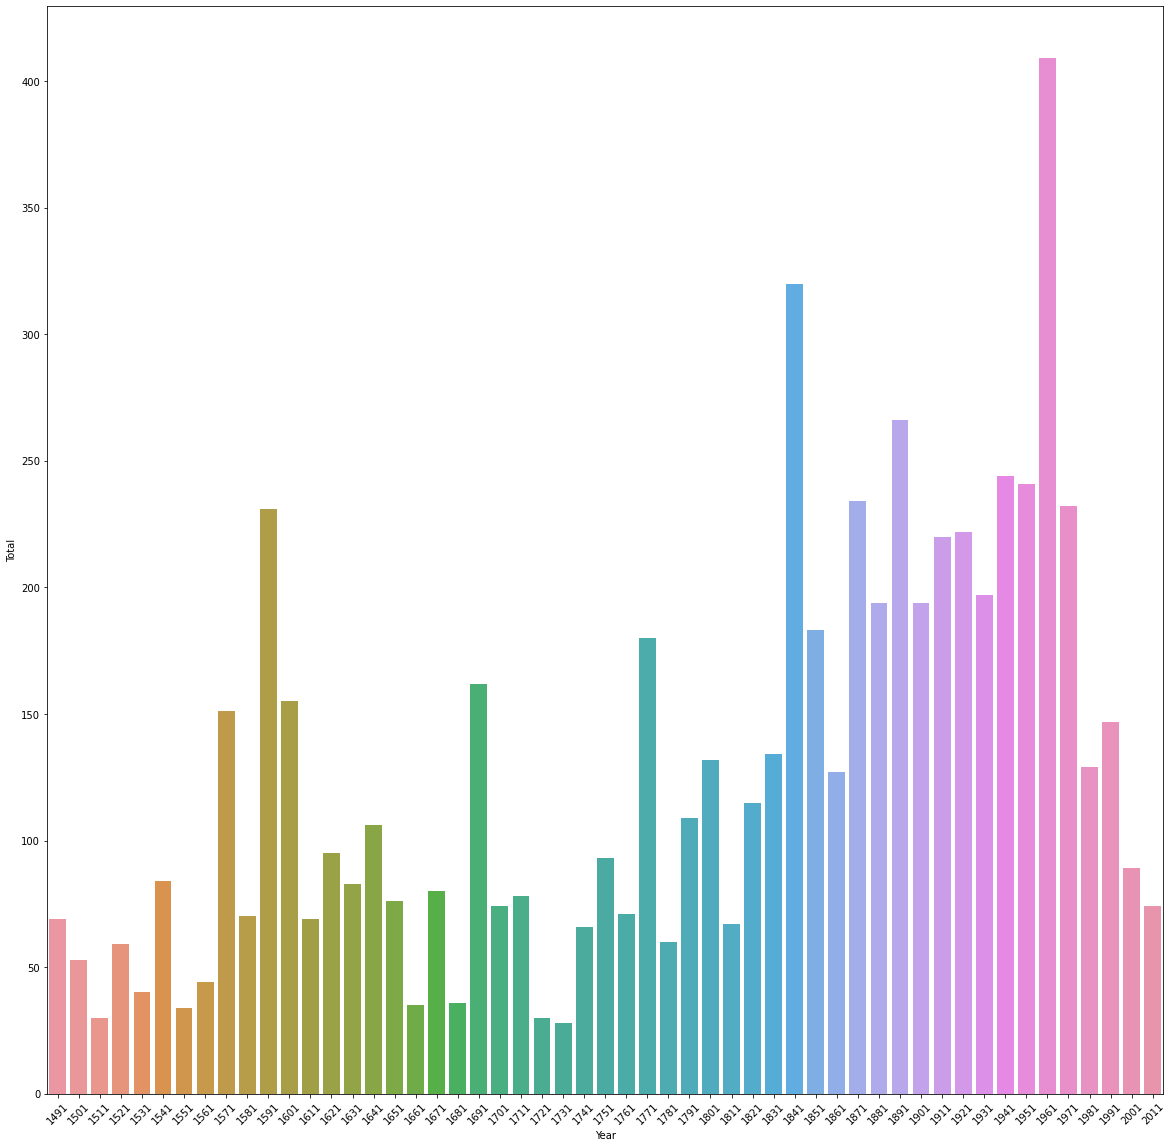

In [20]:
fig, ax = plt.subplots()
plt.xticks(rotation=45)
plt.rcParams['figure.figsize']=(20,20)
plt.rcParams['figure.dpi'] # Figure appears small when first running the notebook unless this line is included.
sns.barplot(x=df_seaborn['Year'][75:], y=df_seaborn['Total'])